# Can overconfidence be eliminated by reserving a portion of the training data to only be optimized for the distribution parameters $\sigma$ and $\alpha$, and unseen by $\mu$?
Specifically, train everything on a large portion of the training data, then forecast the mean of the unseen training data, and train the skewness and variance on that portion.

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import *
from model_objs import *
import vanilla_benchmark

## Pinball Loss

In [4]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

## Vanilla Benchmark Forecast

In [6]:
pre_length = 3 * 365 * 24 // 12  # 3 months
min_train_start = 9 * 365 * 24 + 2 * 24 - pre_length  # 2 leap years from 2005 to 2014
train_starts = np.linspace(min_train_start, min_train_start + 24 * 365 - 24, 12, endpoint=False).astype(int)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [7]:
print(list(train_starts))

[76698, 77426, 78154, 78882, 79610, 80338, 81066, 81794, 82522, 83250, 83978, 84706]


In [8]:
zone_name = "ISONE CA"

In [9]:
vanilla_losses = [397.54593426786477, 604.6018135096928, 329.1556644285198, 197.8631423987858, 323.53210964925717, 415.8909833353536, 544.7284618154562, 540.057213205938, 570.237691916539, 181.8698616921875, 262.12280478463936, 471.97246124553413]
# vanilla_losses = []
# for month in range(1, len(months) + 1):
#     print(months[month-1])
#     vanilla_losses.append(vanilla_benchmark.get_lossesGEFCom(10, 31 * 24, start_date=pd.Timestamp(f"2005-{month}-01"), zones=["ISONE CA"],
#                               delay_days=0, temp_years=np.arange(2005, 2015), plot=True)["ISONE CA"])

In [10]:
for i, loss in list(enumerate(vanilla_losses))[::2]:
    print(np.round(loss, 1), end="\t")

397.5	329.2	323.5	544.7	570.2	262.1	

In [11]:
import json

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))

In [12]:
# rescale data
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)

data (96408, 1)


# Forecasting mean, variance, and skewness of Skew-Normal distribution

In [13]:
%matplotlib inline
z_scores = []
test_z_scores = []
losses = []
relative_perfs = []

TRAIN START: 76698 = 2013-10-01 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: -0.8030050595164518
Loss at iteration 60: -1.6392995119481724
Loss at iteration 110: -1.8921654465675355
Loss at iteration 160: -1.9479152284016572
Loss at iteration 210: -1.9909010197708459
Loss at iteration 260: -2.030622146615057
Loss at iteration 310: -2.059202668876543
Loss at iteration 360: -2.0835546645304603
Loss at iteration 410: -2.1100990303642964
Loss at iteration 460: -2.1285825947680714
Loss at iteration 510: -2.1479562552957048
Loss at iteration 560: -2.168325761582451
Final loss: -2.1828294538467845


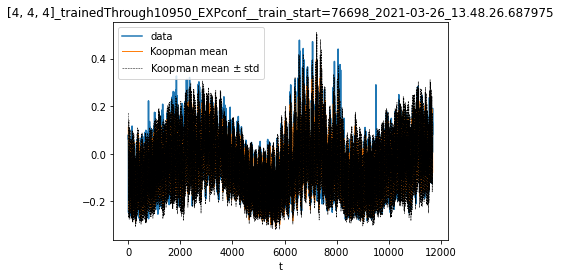

actual overall mean: 0  predicted mean: -0.020372262


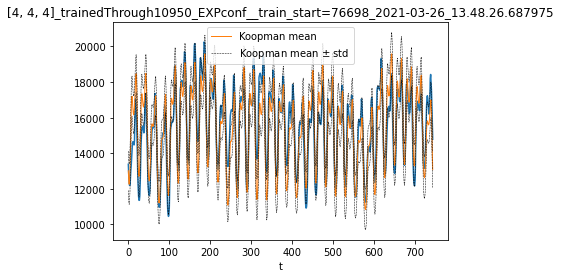

pinball_loss: 305.08699408858024
23.25742315779441% performance relative to vanilla benchmark





TRAIN START: 78154 = 2013-12-01 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: -0.891759086193679
Loss at iteration 60: -1.6008063418401435
Loss at iteration 110: -1.8503322914240512
Loss at iteration 160: -1.9229785808355646
Loss at iteration 210: -1.9747548419220013
Loss at iteration 260: -2.0131792518787557
Loss at iteration 310: -2.0390053474019445
Loss at iteration 360: -2.0677200321799627
Loss at iteration 410: -2.085294434864306
Loss at iteration 460: -2.1015652362905013
Loss at iteration 510: -2.1135484603425136
Loss at iteration 560: -2.1331492391623685
Final loss: -2.140471983324113


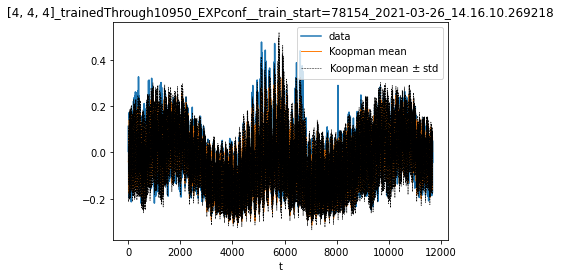

actual overall mean: 0  predicted mean: -0.0036171656


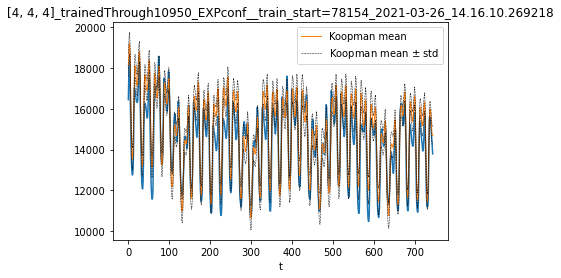

pinball_loss: 264.1394577958573
19.75241919216054% performance relative to vanilla benchmark





TRAIN START: 79610 = 2014-01-31 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: -0.557844435869446
Loss at iteration 60: -1.5683469137281087
Loss at iteration 110: -1.9527591704550766
Loss at iteration 160: -2.007781926812099
Loss at iteration 210: -2.0486045267173454
Loss at iteration 260: -2.0813489057702603
Loss at iteration 310: -2.1121133604092233
Loss at iteration 360: -2.1371702689077474
Loss at iteration 410: -2.155997835281746
Loss at iteration 460: -2.1739795788110987
Loss at iteration 510: -2.194581270977561
Loss at iteration 560: -2.2061023440894187
Final loss: -2.2118348048619567


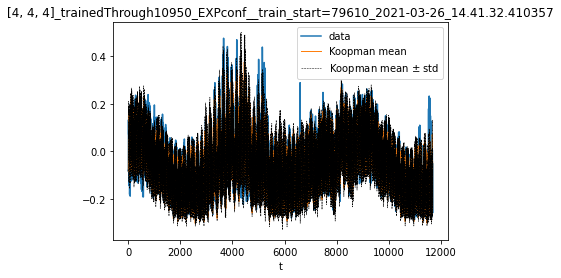

actual overall mean: 0  predicted mean: -0.016507627


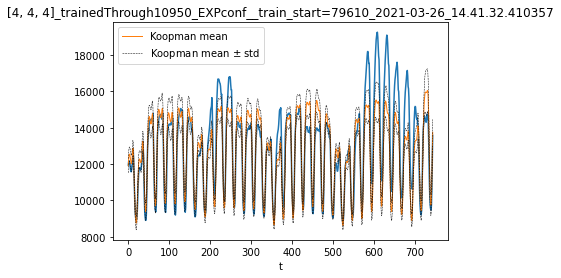

pinball_loss: 332.8222437961892
-2.87147206408771% performance relative to vanilla benchmark





TRAIN START: 81066 = 2014-04-01 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: -0.6777187004391434
Loss at iteration 60: -1.456698164683616


TypeError: _nonzero_dispatcher() got an unexpected keyword argument 'as_tuple'

In [14]:
for month, train_start in list(enumerate(train_starts))[::2]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24 + pre_length
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]
    mask = torch.ones(xt.shape, dtype=torch.uint8)
    mask[:pre_length] = 0
    num_freqs = [4, 4, 4]
    num_fourier = 4
    loss_weights = 1 + 0.4 * torch.cos(torch.linspace(-2 * np.pi * pre_length / xt.shape[0], 2 * np.pi, xt.shape[0]))
    print("x", x.shape)
    print("xt", xt.shape)
    
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "EXPconf_" + f"_train_start={train_start}_" + now

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
    
    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
    
    k.fit(xt, iterations=600, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask);

    fname = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"    

    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params
    
    mean_hat = model.mean(params)
    std_hat = model.std(params)
    
    # ADD TO CORRECT BIAS                                                    
    adjust = np.mean((xt - mean_hat[:train_through]) / std_hat[:train_through]) / (np.mean(1 / std_hat[:train_through]))
    mu_hat += adjust
    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / (1 + ah ** 2) ** 0.5
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

# Figures

In [60]:
from scipy.stats import norm
from sklearn import linear_model

In [222]:
lins = np.linspace(-5, 0, 1000)
denominator = 
m1 = norm.logcdf(lins)
varis = torch.tensor([lins, lins**2, lins**3, lins**4, lins**5]).T
reg = linear_model.LinearRegression()
reg.fit(varis, m1)

LinearRegression()

In [223]:
reg.coef_

array([ 7.94769129e-01, -3.24461588e-01,  3.17831426e-02,  3.61951115e-03,
        1.84229081e-04])

<class 'numpy.ndarray'>


<ipython-input-330-2d5d8832dddd>:7: RuntimeWarning: divide by zero encountered in true_divide
  approx = lambda x: np.where(x<-0.1, -0.5*x**2 - 4.8 + 2509*(x - 13) / ((x - 40)**2 * (x - 5)), -np.exp(-x*2) / 2 - np.exp(-(x-0.2)**2) * 0.2)


<IPython.core.display.Javascript object>


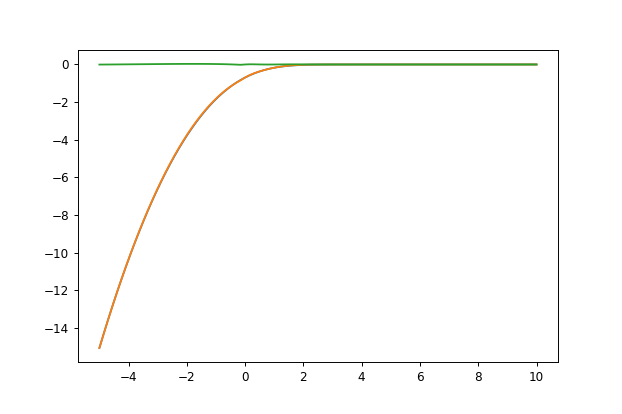

In [330]:
plt.close("all")
lins = np.linspace(-5, 10, 100)
denominator = (lins + 20) ** 4
varis = torch.tensor([lins, lins**2, lins**3, lins**4, lins**5]).T

# approx = lambda x: -0.5*x**2 - 4.8 + 2509*(x - 13) / ((x - 40)**2 * (x - 5))
approx = lambda x: np.where(x<-0.1, -0.5*x**2 - 4.8 + 2509*(x - 13) / ((x - 40)**2 * (x - 5)), -np.exp(-x*2) / 2 - np.exp(-(x-0.2)**2) * 0.2)
# approx = lambda x: -0.5*x**2 - 4.8 + 2509*(x - 13) *(1 / (1 + 0.42 * (x - 5)**-2)) / ((x - 40)**2 * (x - 5))
# approx2 = lambda x: np.log(1 - np.exp(1.4 * x)) - np.log(-x) - 0.5 * x ** 2 - 1.04557
# approx = lambda x: -15/((x + 2.1)**4)
# approx = lambda x: -np.exp(-x*2) / 2 - np.exp(-(x-0.2)**2) * 0.2
# rational = lambda x: -10 / (x + 100)
approx3 = lambda x: sum(reg.coef_ * varis) + reg.intercept_
torchnorm = torch.distributions.normal.Normal(0, 1)
m1 = norm.logcdf(lins)
# m2 = np.log(torchnorm.cdf(lins))
m3 = approx(lins)
# m4 = reg.predict(varis)
print(type(m4))
plt.plot(lins, m1)
# plt.plot(lins, m2)
plt.plot(lins, m3)
plt.plot(lins, (m3 - m1))
plt.show()

In [171]:
# for tables
for loss in losses[:6]:
    print(np.round(loss, 1), end="\t")
print("")
for rel in relative_perfs[:6]:
    print(np.round(rel, 1), end="%\t")

305.1	264.1	332.8	
23.3%	19.8%	-2.9%	

In [16]:
idx = 6
for z_score in z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")

0.0	0.0	-0.0	0.0	0.0	0.0	
0.99	0.97	0.98	1.0	0.97	0.99	
0.46	0.32	0.45	0.6	0.49	0.55	
-0.06	-0.32	0.83	0.36	0.59	-1.11	
1.11	1.19	2.19	1.41	1.59	1.59	
-0.0	0.07	0.68	1.38	1.14	0.02	

In [202]:
z_scores = np.array(z_scores)
test_z_scores = np.array(test_z_scores)
losses = np.array(losses)
relative = np.array(relative_perfs)

In [203]:
np.save("experiments\\" + data_name + "z_scores.npy", z_scores)
np.save("experiments\\" + data_name + "test_z_scores.npy", test_z_scores)
np.save("experiments\\" + data_name + "relative_perfs.npy", relative_perfs)
np.save("experiments\\" + data_name + "losses.npy", losses)

Text(0, 0.5, 'standardized residual $z$')

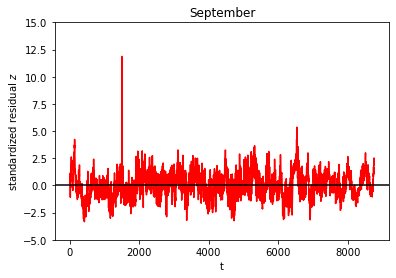

In [211]:
plt.plot(z_scores[4], color="r")
plt.title("September")
plt.axhline(0, color="k")
plt.xlabel("t")
plt.ylim([-5, 15])
plt.ylabel("standardized residual $z$")

In [96]:
zs = (xt - mu_hat[:train_through]) / sigma_hat[:train_through]

In [97]:
b = np.mean(zs)

In [98]:
a = b / (np.mean(1 / sigma_hat[:train_through]))

In [99]:
a

0.03618646150443811

In [100]:
zsc = (xt - (mu_hat[:train_through] + a)) / sigma_hat[:train_through]

In [101]:
zsc.mean()

1.130180568147571e-07